### **Semantic Segmentation**




In [1]:
! git clone https://github.com/sunghoonYoon/Kitti_TA

Cloning into 'Kitti_TA'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 47 (delta 11), reused 47 (delta 11), pack-reused 0
Unpacking objects: 100% (47/47), done.


In [ ]:
"""
This code is from https://github.com/NVIDIA/semantic-segmentation
"""


"""
Custom Norm wrappers to enable sync BN, regular BN and for weight initialization
"""
import torch.nn as nn
# from config import cfg

# from apex import amp

def Norm2d(in_channels):
    """
    Custom Norm Function to allow flexible switching
    """
    layer = torch.nn.BatchNorm2d #getattr(cfg.MODEL, 'BNFUNC')
    normalization_layer = layer(in_channels)
    return normalization_layer


def initialize_weights(*models):
    """
    Initialize Model Weights
    """
    for model in models:
        for module in model.modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()


# @amp.float_function
def Upsample(x, size):
    """
    Wrapper Around the Upsample Call
    """
    return nn.functional.interpolate(x, size=size, mode='bilinear',
                                     align_corners=True)


In [ ]:
"""
# Code adapted from:
# https://github.com/mapillary/inplace_abn/
#
# BSD 3-Clause License
#
# Copyright (c) 2017, mapillary
# All rights reserved.
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
#
# * Redistributions of source code must retain the above copyright notice, this
#   list of conditions and the following disclaimer.
#
# * Redistributions in binary form must reproduce the above copyright notice,
#   this list of conditions and the following disclaimer in the documentation
#   and/or other materials provided with the distribution.
#
# * Neither the name of the copyright holder nor the names of its
#   contributors may be used to endorse or promote products derived from
#   this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
"""
import logging
import sys
from collections import OrderedDict
from functools import partial
import torch.nn as nn
import torch
# import network.mynn as mynn

def bnrelu(channels):
    """
    Single Layer BN and Relui
    """
    return nn.Sequential(Norm2d(channels),
                         nn.ReLU(inplace=True))

class GlobalAvgPool2d(nn.Module):
    """
    Global average pooling over the input's spatial dimensions
    """

    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()
        logging.info("Global Average Pooling Initialized")

    def forward(self, inputs):
        in_size = inputs.size()
        return inputs.view((in_size[0], in_size[1], -1)).mean(dim=2)


class IdentityResidualBlock(nn.Module):
    """
    Identity Residual Block for WideResnet
    """
    def __init__(self,
                 in_channels,
                 channels,
                 stride=1,
                 dilation=1,
                 groups=1,
                 norm_act=bnrelu,
                 dropout=None,
                 dist_bn=False
                 ):
        """Configurable identity-mapping residual block

        Parameters
        ----------
        in_channels : int
            Number of input channels.
        channels : list of int
            Number of channels in the internal feature maps.
            Can either have two or three elements: if three construct
            a residual block with two `3 x 3` convolutions,
            otherwise construct a bottleneck block with `1 x 1`, then
            `3 x 3` then `1 x 1` convolutions.
        stride : int
            Stride of the first `3 x 3` convolution
        dilation : int
            Dilation to apply to the `3 x 3` convolutions.
        groups : int
            Number of convolution groups.
            This is used to create ResNeXt-style blocks and is only compatible with
            bottleneck blocks.
        norm_act : callable
            Function to create normalization / activation Module.
        dropout: callable
            Function to create Dropout Module.
        dist_bn: Boolean
            A variable to enable or disable use of distributed BN
        """
        super(IdentityResidualBlock, self).__init__()
        self.dist_bn = dist_bn

        # Check if we are using distributed BN and use the nn from encoding.nn
        # library rather than using standard pytorch.nn


        # Check parameters for inconsistencies
        if len(channels) != 2 and len(channels) != 3:
            raise ValueError("channels must contain either two or three values")
        if len(channels) == 2 and groups != 1:
            raise ValueError("groups > 1 are only valid if len(channels) == 3")

        is_bottleneck = len(channels) == 3
        need_proj_conv = stride != 1 or in_channels != channels[-1]

        self.bn1 = norm_act(in_channels)
        if not is_bottleneck:
            layers = [
                ("conv1", nn.Conv2d(in_channels,
                                    channels[0],
                                    3,
                                    stride=stride,
                                    padding=dilation,
                                    bias=False,
                                    dilation=dilation)),
                ("bn2", norm_act(channels[0])),
                ("conv2", nn.Conv2d(channels[0], channels[1],
                                    3,
                                    stride=1,
                                    padding=dilation,
                                    bias=False,
                                    dilation=dilation))
            ]
            if dropout is not None:
                layers = layers[0:2] + [("dropout", dropout())] + layers[2:]
        else:
            layers = [
                ("conv1",
                 nn.Conv2d(in_channels,
                           channels[0],
                           1,
                           stride=stride,
                           padding=0,
                           bias=False)),
                ("bn2", norm_act(channels[0])),
                ("conv2", nn.Conv2d(channels[0],
                                    channels[1],
                                    3, stride=1,
                                    padding=dilation, bias=False,
                                    groups=groups,
                                    dilation=dilation)),
                ("bn3", norm_act(channels[1])),
                ("conv3", nn.Conv2d(channels[1], channels[2],
                                    1, stride=1, padding=0, bias=False))
            ]
            if dropout is not None:
                layers = layers[0:4] + [("dropout", dropout())] + layers[4:]
        self.convs = nn.Sequential(OrderedDict(layers))

        if need_proj_conv:
            self.proj_conv = nn.Conv2d(
                in_channels, channels[-1], 1, stride=stride, padding=0, bias=False)

    def forward(self, x):
        """
        This is the standard forward function for non-distributed batch norm
        """
        if hasattr(self, "proj_conv"):
            bn1 = self.bn1(x)
            shortcut = self.proj_conv(bn1)
        else:
            shortcut = x.clone()
            bn1 = self.bn1(x)

        out = self.convs(bn1)
        out.add_(shortcut)
        return out




class WiderResNet(nn.Module):
    """
    WideResnet Global Module for Initialization
    """
    def __init__(self,
                 structure,
                 norm_act=bnrelu,
                 classes=0
                 ):
        """Wider ResNet with pre-activation (identity mapping) blocks

        Parameters
        ----------
        structure : list of int
            Number of residual blocks in each of the six modules of the network.
        norm_act : callable
            Function to create normalization / activation Module.
        classes : int
            If not `0` also include global average pooling and \
            a fully-connected layer with `classes` outputs at the end
            of the network.
        """
        super(WiderResNet, self).__init__()
        self.structure = structure

        if len(structure) != 6:
            raise ValueError("Expected a structure with six values")

        # Initial layers
        self.mod1 = nn.Sequential(OrderedDict([
            ("conv1", nn.Conv2d(3, 64, 3, stride=1, padding=1, bias=False))
        ]))

        # Groups of residual blocks
        in_channels = 64
        channels = [(128, 128), (256, 256), (512, 512), (512, 1024),
                    (512, 1024, 2048), (1024, 2048, 4096)]
        for mod_id, num in enumerate(structure):
            # Create blocks for module
            blocks = []
            for block_id in range(num):
                blocks.append((
                    "block%d" % (block_id + 1),
                    IdentityResidualBlock(in_channels, channels[mod_id],
                                          norm_act=norm_act)
                ))

                # Update channels and p_keep
                in_channels = channels[mod_id][-1]

            # Create module
            if mod_id <= 4:
                self.add_module("pool%d" %
                                (mod_id + 2), nn.MaxPool2d(3, stride=2, padding=1))
            self.add_module("mod%d" % (mod_id + 2), nn.Sequential(OrderedDict(blocks)))

        # Pooling and predictor
        self.bn_out = norm_act(in_channels)
        if classes != 0:
            self.classifier = nn.Sequential(OrderedDict([
                ("avg_pool", GlobalAvgPool2d()),
                ("fc", nn.Linear(in_channels, classes))
            ]))

    def forward(self, img):
        out = self.mod1(img)
        out = self.mod2(self.pool2(out))
        out = self.mod3(self.pool3(out))
        out = self.mod4(self.pool4(out))
        out = self.mod5(self.pool5(out))
        out = self.mod6(self.pool6(out))
        out = self.mod7(out)
        out = self.bn_out(out)

        if hasattr(self, "classifier"):
            out = self.classifier(out)

        return out


class WiderResNetA2(nn.Module):
    """
    Wider ResNet with pre-activation (identity mapping) blocks

    This variant uses down-sampling by max-pooling in the first two blocks and
     by strided convolution in the others.

    Parameters
    ----------
    structure : list of int
        Number of residual blocks in each of the six modules of the network.
    norm_act : callable
        Function to create normalization / activation Module.
    classes : int
        If not `0` also include global average pooling and a fully-connected layer
        with `classes` outputs at the end
        of the network.
    dilation : bool
        If `True` apply dilation to the last three modules and change the
        down-sampling factor from 32 to 8.
    """
    def __init__(self,
                 structure,
                 norm_act=bnrelu,
                 classes=0,
                 dilation=False,
                 dist_bn=False
                 ):
        super(WiderResNetA2, self).__init__()
        self.dist_bn = dist_bn

        # If using distributed batch norm, use the encoding.nn as oppose to torch.nn


        nn.Dropout = nn.Dropout2d
        norm_act = bnrelu
        self.structure = structure
        self.dilation = dilation

        if len(structure) != 6:
            raise ValueError("Expected a structure with six values")

        # Initial layers
        self.mod1 = torch.nn.Sequential(OrderedDict([
            ("conv1", nn.Conv2d(3, 64, 3, stride=1, padding=1, bias=False))
        ]))

        # Groups of residual blocks
        in_channels = 64
        channels = [(128, 128), (256, 256), (512, 512), (512, 1024), (512, 1024, 2048),
                    (1024, 2048, 4096)]
        for mod_id, num in enumerate(structure):
            # Create blocks for module
            blocks = []
            for block_id in range(num):
                if not dilation:
                    dil = 1
                    stride = 2 if block_id == 0 and 2 <= mod_id <= 4 else 1
                else:
                    if mod_id == 3:
                        dil = 2
                    elif mod_id > 3:
                        dil = 4
                    else:
                        dil = 1
                    stride = 2 if block_id == 0 and mod_id == 2 else 1

                if mod_id == 4:
                    drop = partial(nn.Dropout, p=0.3)
                elif mod_id == 5:
                    drop = partial(nn.Dropout, p=0.5)
                else:
                    drop = None

                blocks.append((
                    "block%d" % (block_id + 1),
                    IdentityResidualBlock(in_channels,
                                          channels[mod_id], norm_act=norm_act,
                                          stride=stride, dilation=dil,
                                          dropout=drop, dist_bn=self.dist_bn)
                ))

                # Update channels and p_keep
                in_channels = channels[mod_id][-1]

            # Create module
            if mod_id < 2:
                self.add_module("pool%d" %
                                (mod_id + 2), nn.MaxPool2d(3, stride=2, padding=1))
            self.add_module("mod%d" % (mod_id + 2), nn.Sequential(OrderedDict(blocks)))

        # Pooling and predictor
        self.bn_out = norm_act(in_channels)
        if classes != 0:
            self.classifier = nn.Sequential(OrderedDict([
                ("avg_pool", GlobalAvgPool2d()),
                ("fc", nn.Linear(in_channels, classes))
            ]))

    def forward(self, img):
        out = self.mod1(img)
        out = self.mod2(self.pool2(out))
        out = self.mod3(self.pool3(out))
        out = self.mod4(out)
        out = self.mod5(out)
        out = self.mod6(out)
        out = self.mod7(out)
        out = self.bn_out(out)

        if hasattr(self, "classifier"):
            return self.classifier(out)
        return out


_NETS = {
    "16": {"structure": [1, 1, 1, 1, 1, 1]},
    "20": {"structure": [1, 1, 1, 3, 1, 1]},
    "38": {"structure": [3, 3, 6, 3, 1, 1]},
}

__all__ = []
for name, params in _NETS.items():
    net_name = "wider_resnet" + name
    setattr(sys.modules[__name__], net_name, partial(WiderResNet, **params))
    __all__.append(net_name)
for name, params in _NETS.items():
    net_name = "wider_resnet" + name + "_a2"
    setattr(sys.modules[__name__], net_name, partial(WiderResNetA2, **params))
    __all__.append(net_name)

In [ ]:

class _AtrousSpatialPyramidPoolingModule(nn.Module):
    """
    operations performed:
      1x1 x depth
      3x3 x depth dilation 6
      3x3 x depth dilation 12
      3x3 x depth dilation 18
      image pooling
      concatenate all together
      Final 1x1 conv
    """

    def __init__(self, in_dim, reduction_dim=256, output_stride=16, rates=(6, 12, 18)):
        super(_AtrousSpatialPyramidPoolingModule, self).__init__()

        # Check if we are using distributed BN and use the nn from encoding.nn
        # library rather than using standard pytorch.nn

        if output_stride == 8:
            rates = [2 * r for r in rates]
        elif output_stride == 16:
            pass
        else:
            raise 'output stride of {} not supported'.format(output_stride)

        self.features = []
        # 1x1
        self.features.append(
            nn.Sequential(nn.Conv2d(in_dim, reduction_dim, kernel_size=1, bias=False),
                          Norm2d(reduction_dim), nn.ReLU(inplace=True)))
        # other rates
        for r in rates:
            self.features.append(nn.Sequential(
                nn.Conv2d(in_dim, reduction_dim, kernel_size=3,
                          dilation=r, padding=r, bias=False),
                Norm2d(reduction_dim),
                nn.ReLU(inplace=True)
            ))
        self.features = torch.nn.ModuleList(self.features)

        # img level features
        self.img_pooling = nn.AdaptiveAvgPool2d(1)
        self.img_conv = nn.Sequential(
            nn.Conv2d(in_dim, reduction_dim, kernel_size=1, bias=False),
            Norm2d(reduction_dim), nn.ReLU(inplace=True))

    def forward(self, x):
        x_size = x.size()

        img_features = self.img_pooling(x)
        img_features = self.img_conv(img_features)
        img_features = Upsample(img_features, x_size[2:])
        out = img_features

        for f in self.features:
            y = f(x)
            out = torch.cat((out, y), 1)
        return out

In [ ]:

class DeepWV3Plus(nn.Module):
    """
    Wide_resnet version of DeepLabV3
    mod1
    pool2
    mod2 str2
    pool3
    mod3-7

      structure: [3, 3, 6, 3, 1, 1]
      channels = [(128, 128), (256, 256), (512, 512), (512, 1024), (512, 1024, 2048),
                  (1024, 2048, 4096)]
    """

    def __init__(self, num_classes, trunk='WideResnet38', criterion=None):

        super(DeepWV3Plus, self).__init__()
        self.criterion = criterion
        logging.info("Trunk: %s", trunk)
        wide_resnet = wider_resnet38_a2(classes=1000, dilation=True)
        # TODO: Should this be even here ?
        wide_resnet = torch.nn.DataParallel(wide_resnet)
        try:
            checkpoint = torch.load('./pretrained_models/wider_resnet38.pth.tar', map_location='cpu')
            wide_resnet.load_state_dict(checkpoint['state_dict'])
            del checkpoint
        except:
            print("=====================Could not load ImageNet weights=======================")
            print("Please download the ImageNet weights of WideResNet38 in our repo to ./pretrained_models.")

        wide_resnet = wide_resnet.module

        self.mod1 = wide_resnet.mod1
        self.mod2 = wide_resnet.mod2
        self.mod3 = wide_resnet.mod3
        self.mod4 = wide_resnet.mod4
        self.mod5 = wide_resnet.mod5
        self.mod6 = wide_resnet.mod6
        self.mod7 = wide_resnet.mod7
        self.pool2 = wide_resnet.pool2
        self.pool3 = wide_resnet.pool3
        del wide_resnet

        self.aspp = _AtrousSpatialPyramidPoolingModule(4096, 256,
                                                       output_stride=8)

        self.bot_fine = nn.Conv2d(128, 48, kernel_size=1, bias=False)
        self.bot_aspp = nn.Conv2d(1280, 256, kernel_size=1, bias=False)

        self.final = nn.Sequential(
            nn.Conv2d(256 + 48, 256, kernel_size=3, padding=1, bias=False),
            Norm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            Norm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_classes, kernel_size=1, bias=False))

        initialize_weights(self.final)

    def forward(self, inp, gts=None):

        x_size = inp.size()
        x = self.mod1(inp)
        m2 = self.mod2(self.pool2(x))
        x = self.mod3(self.pool3(m2))
        x = self.mod4(x)
        x = self.mod5(x)
        x = self.mod6(x)
        x = self.mod7(x)
        x = self.aspp(x)
        dec0_up = self.bot_aspp(x)

        dec0_fine = self.bot_fine(m2)
        dec0_up = Upsample(dec0_up, m2.size()[2:])
        dec0 = [dec0_fine, dec0_up]
        dec0 = torch.cat(dec0, 1)

        dec1 = self.final(dec0)
        out = Upsample(dec1, x_size[2:])

        if self.training:
            return self.criterion(out, gts)

        return out

In [ ]:
net = DeepWV3Plus(num_classes=19).cuda()
state_dict= torch.load('/content/drive/MyDrive/ME459_segmentation/cityscapes_best.pth')
net = torch.nn.DataParallel(net)

# print(state_dict)
net.load_state_dict(state_dict['state_dict'],strict=False)

net.eval()


=====================Could not load ImageNet weights=======================
Please download the ImageNet weights of WideResNet38 in our repo to ./pretrained_models.


DataParallel(
  (module): DeepWV3Plus(
    (mod1): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (mod2): Sequential(
      (block1): IdentityResidualBlock(
        (bn1): Sequential(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU(inplace=True)
        )
        (convs): Sequential(
          (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): Sequential(
            (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace=True)
          )
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (proj_conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (block2): IdentityResidualBlock(
        (bn1): Sequential(
          (0): BatchNorm2d(128, eps=1e-05

In [ ]:

def decode_segmap(temp):
    colors = [  # [  0,   0,   0],
        [128, 64, 128],#road
        [244, 35, 232],#sidewalk
        [70, 70, 70],#building
        [102, 102, 156],#wall
        [190, 153, 153],#fence
        [153, 153, 153],#pole
        [250, 170, 30],#traffic light
        [220, 220, 0],#trafiic sign
        [107, 142, 35],  # vegetation dark green
        [152, 251, 152],  # terrain bright green
        [0, 130, 180],#sky
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]

    label_colours = dict(zip(range(19), colors))
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, 19):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb

In [ ]:
from PIL import Image
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt




image= np.asarray(Image.open('/content/drive/MyDrive/ME459_segmentation/kaist_road.jpg').convert('RGB'))
MEAN = [0.45734706, 0.43338275, 0.40058118]
STD = [0.23965294, 0.23532275, 0.2398498]

toTensor = transforms.ToTensor()
normTensor = transforms.Normalize(MEAN,STD)
imageT = normTensor(toTensor(image))

with torch.no_grad():
  for i in [1]:
    imageT = F.interpolate(imageT.unsqueeze(0), size=(512,1024),mode='bilinear',align_corners=True)
    out = net(imageT.cuda())


prob = F.softmax(out,1)
pred = np.argmax(prob[0].detach().cpu().numpy(),axis=0)



/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_m

In [ ]:
def denorm(img):
    # ImageNet statistics
    mean_img = [0.485, 0.456, 0.406]
    std_img = [0.229, 0.224, 0.225]

    tf_denorm = transforms.Normalize(mean = [-mean_img[0] / std_img[0], -mean_img[1] / std_img[1], -mean_img[2] / std_img[2]],
                                     std = [1 / std_img[0], 1 / std_img[1], 1 / std_img[2]])

    return tf_denorm(img)

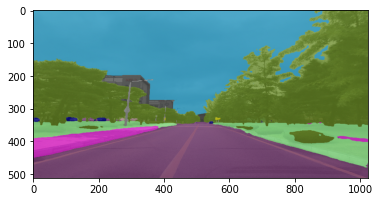

In [ ]:
segmap = decode_segmap(pred)

plt.imshow(denorm(imageT)[0].permute(1,2,0))
plt.imshow(segmap,alpha=0.7)
plt.show()

# categories = ['bg','aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
#                   'bus', 'car', 'cat', 'chair', 'cow',
#                   'diningtable', 'dog', 'horse', 'motorbike', 'person',
#                   'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
# class_pred = np.unique(pred)

# print("Class Exist::")

# for i in range(len(class_pred)):
#   print(categories[class_pred[i]]+',',end='')

### **Stereo Matching**

In [12]:
from __future__ import print_function 
import torch 
import torch.nn as nn 
import torch.utils.data 
from torch.autograd import Variable 
import torch.nn.functional as F
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
import time

from Kitti_TA.PSMnet.submodule import *
from Kitti_TA.PSMnet.preprocess import *
from Kitti_TA.PSMnet.dataloader import listflowfile as lt
from Kitti_TA.PSMnet.dataloader.KITTILoader import *
from Kitti_TA.PSMnet.dataloader.KITTIloader2015 import *

In [15]:
datapath = '/content/drive/MyDrive/ME459_stereo/KITTI_2015/training/'
all_left_img, all_right_img, all_left_disp, test_left_img, test_right_img, test_left_disp = dataloader(datapath)
print('left image string:', all_left_img[0])
print('right image string: ', all_right_img[0])
print('left disparity string: ', all_left_disp[0])
print('test left image string: ',test_left_img[0])
print('test right image string: ', test_right_img[0])

left image string: /content/drive/MyDrive/ME459_stereo/KITTI_2015/training/image_2/000090_10.png
right image string:  /content/drive/MyDrive/ME459_stereo/KITTI_2015/training/image_3/000090_10.png
left disparity string:  /content/drive/MyDrive/ME459_stereo/KITTI_2015/training/disp_occ_0/000090_10.png
test left image string:  /content/drive/MyDrive/ME459_stereo/KITTI_2015/training/image_2/000153_10.png
test right image string:  /content/drive/MyDrive/ME459_stereo/KITTI_2015/training/image_3/000153_10.png


In [16]:
KITTI_dataset_test = myImageFloder(test_left_img, test_right_img, test_left_disp, True)
TestImgLoader = torch.utils.data.DataLoader(KITTI_dataset_test, \
                batch_size=8, shuffle= False, num_workers= 4, drop_last=False)
print('Test object: ', TestImgLoader)

Test object:  <torch.utils.data.dataloader.DataLoader object at 0x7fbf955ab5d0>


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

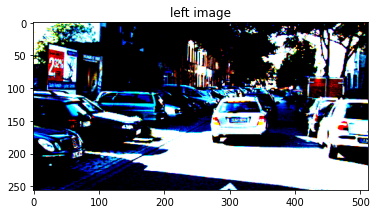

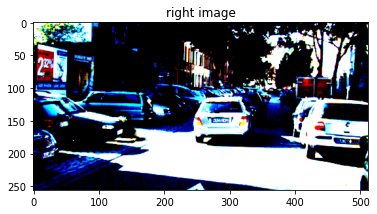

<Figure size 432x288 with 0 Axes>

In [17]:
left_img, right_img, left_disp = KITTI_dataset_test.__getitem__(0)
plt.figure()
plt.title('left image')
plt.imshow(left_img.detach().cpu().numpy().transpose(1,2,0))
plt.figure()
plt.title('right image')
plt.imshow(right_img.detach().cpu().numpy().transpose(1,2,0))
plt.figure()


In [36]:
def convbn(in_planes, out_planes, kernel_size, stride, pad, dilation):
    return nn.Sequential(nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=dilation if dilation > 1 else pad, dilation = dilation, bias=False), \
                         nn.BatchNorm2d(out_planes))

class feature_extraction(nn.Module):
    def __init__(self):
        super(feature_extraction, self).__init__()
        self.inplanes = 32
        self.firstconv = nn.Sequential(convbn(3, 32, 3, 2, 1, 1),
                                       nn.ReLU(inplace=True),
                                       convbn(32, 32, 3, 1, 1, 1),
                                       nn.ReLU(inplace=True),
                                       convbn(32, 32, 3, 1, 1, 1),
                                       nn.ReLU(inplace=True))

        self.layer1 = self._make_layer(BasicBlock, 32, 3, 1,1,1)
        self.layer2 = self._make_layer(BasicBlock, 64, 16, 2,1,1) 
        self.layer3 = self._make_layer(BasicBlock, 128, 3, 1,1,1)
        self.layer4 = self._make_layer(BasicBlock, 128, 3, 1,1,2)

        ## Your implementation Here - Spatial pyramid pooling module
        self.branch1 = nn.Sequential(nn.AvgPool2d((64, 64), stride=(64,64)),
                                     convbn(128, 32, 1, 1, 0, 1),
                                     nn.ReLU(inplace=True))

        self.branch2 = nn.Sequential(nn.AvgPool2d((32, 32), stride=(32,32)),
                                     convbn(128, 32, 1, 1, 0, 1),
                                     nn.ReLU(inplace=True))

        self.branch3 = nn.Sequential(nn.AvgPool2d((16, 16), stride=(16,16)),
                                     convbn(128, 32, 1, 1, 0, 1),
                                     nn.ReLU(inplace=True))

        self.branch4 = nn.Sequential(nn.AvgPool2d((8, 8), stride=(8,8)),
                                     convbn(128, 32, 1, 1, 0, 1),
                                     nn.ReLU(inplace=True))
        ## Your implementation end - Spatial pyramid pooling module   

        self.lastconv = nn.Sequential(convbn(320, 128, 3, 1, 1, 1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(128, 32, kernel_size=1, padding=0, stride = 1, bias=False))

    def _make_layer(self, block, planes, blocks, stride, pad, dilation):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
           downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),)

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, pad, dilation))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes,1,None,pad,dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        output      = self.firstconv(x)
        output      = self.layer1(output)
        output_raw  = self.layer2(output)
        output      = self.layer3(output_raw)
        output_skip = self.layer4(output)


        output_branch1 = self.branch1(output_skip)
        output_branch1 = F.upsample(output_branch1, (output_skip.size()[2],output_skip.size()[3]),mode='bilinear')

        output_branch2 = self.branch2(output_skip)
        output_branch2 = F.upsample(output_branch2, (output_skip.size()[2],output_skip.size()[3]),mode='bilinear')

        output_branch3 = self.branch3(output_skip)
        output_branch3 = F.upsample(output_branch3, (output_skip.size()[2],output_skip.size()[3]),mode='bilinear')

        output_branch4 = self.branch4(output_skip)
        output_branch4 = F.upsample(output_branch4, (output_skip.size()[2],output_skip.size()[3]),mode='bilinear')

        output_feature = torch.cat((output_raw, output_skip, output_branch4, output_branch3, output_branch2, output_branch1), 1)
        output_feature = self.lastconv(output_feature)

        return output_feature

In [38]:
def convbn_3d(in_planes, out_planes, kernel_size, stride, pad):
    return nn.Sequential(nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, padding=pad, stride=stride,bias=False),
                         nn.BatchNorm3d(out_planes))
class hourglass(nn.Module):
    def __init__(self, inplanes):
        super(hourglass, self).__init__()
        ## Your implementation Here - Hourglass module
        self.conv1 = nn.Sequential(convbn_3d(inplanes, inplanes*2, kernel_size=3, stride=2, pad=1),
                                   nn.ReLU(inplace=True))
        self.conv2 = convbn_3d(inplanes*2, inplanes*2, kernel_size=3, stride=1, pad=1)
        self.conv3 = nn.Sequential(convbn_3d(inplanes*2, inplanes*2, kernel_size=3, stride=2, pad=1),
                                   nn.ReLU(inplace=True))
        self.conv4 = nn.Sequential(convbn_3d(inplanes*2, inplanes*2, kernel_size=3, stride=1, pad=1),
                                   nn.ReLU(inplace=True))
        self.conv5 = nn.Sequential(nn.ConvTranspose3d(inplanes*2, inplanes*2, kernel_size=3, padding=1, output_padding=1, stride=2,bias=False),
                                   nn.BatchNorm3d(inplanes*2)) #+conv2
        self.conv6 =  nn.Sequential(nn.ConvTranspose3d(inplanes*2, inplanes, kernel_size=3, padding=1, output_padding=1, stride=2,bias=False),
                                   nn.BatchNorm3d(inplanes)) #+x
        ## Your implementation end - Hourglass module

    def forward(self, x, presqu, postsqu):
        
        out  = self.conv1(x) #in:1/4 out:1/8
        pre  = self.conv2(out) #in:1/8 out:1/8
        if postsqu is not None:
           pre = F.relu(pre + postsqu, inplace=True)
        else:
           pre = F.relu(pre, inplace=True)

        out  = self.conv3(pre) #in:1/8 out:1/16
        out  = self.conv4(out) #in:1/16 out:1/16

        if presqu is not None:
           post = F.relu(self.conv5(out)+presqu, inplace=True) #in:1/16 out:1/8
        else:
           post = F.relu(self.conv5(out)+pre, inplace=True) 

        out  = self.conv6(post)  #in:1/8 out:1/4
        return out, pre, post

In [21]:
class PSMNet(nn.Module):
    def __init__(self, maxdisp):
        super(PSMNet, self).__init__()
        self.maxdisp = maxdisp
        # step1 - feature extractor 
        self.feature_extraction = feature_extraction()
        # step2 - 3D convolution part
        self.dres0 = nn.Sequential(convbn_3d(64, 32, 3, 1, 1),
                                     nn.ReLU(inplace=True),
                                     convbn_3d(32, 32, 3, 1, 1),
                                     nn.ReLU(inplace=True))

        self.dres1 = nn.Sequential(convbn_3d(32, 32, 3, 1, 1),
                                   nn.ReLU(inplace=True),
                                   convbn_3d(32, 32, 3, 1, 1)) 

        self.dres2 = hourglass(32)
        self.dres3 = hourglass(32)
        self.dres4 = hourglass(32)

        self.classif1 = nn.Sequential(convbn_3d(32, 32, 3, 1, 1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv3d(32, 1, kernel_size=3, padding=1, stride=1,bias=False))

        self.classif2 = nn.Sequential(convbn_3d(32, 32, 3, 1, 1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv3d(32, 1, kernel_size=3, padding=1, stride=1,bias=False))

        self.classif3 = nn.Sequential(convbn_3d(32, 32, 3, 1, 1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv3d(32, 1, kernel_size=3, padding=1, stride=1,bias=False))
        
        # Step3 - weight initialization 
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.Conv3d):
                n = m.kernel_size[0] * m.kernel_size[1]*m.kernel_size[2] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()


    def forward(self, left, right):
        # Step 1 - feature extraction
        refimg_fea     = self.feature_extraction(left)
        targetimg_fea  = self.feature_extraction(right)


        # Step 2: make cost volume.
        cost = Variable(torch.FloatTensor(refimg_fea.size()[0], refimg_fea.size()[1]*2, self.maxdisp//4,  refimg_fea.size()[2],  refimg_fea.size()[3]).zero_()).cuda()

        for i in range(self.maxdisp//4):
            if i > 0 :
             cost[:, :refimg_fea.size()[1], i, :,i:]   = refimg_fea[:,:,:,i:]
             cost[:, refimg_fea.size()[1]:, i, :,i:] = targetimg_fea[:,:,:,:-i]
            else:
             cost[:, :refimg_fea.size()[1], i, :,:]   = refimg_fea
             cost[:, refimg_fea.size()[1]:, i, :,:]   = targetimg_fea
        cost = cost.contiguous()
        # Step 3: Perform 3D convolution.
        cost0 = self.dres0(cost)
        cost0 = self.dres1(cost0) + cost0

        out1, pre1, post1 = self.dres2(cost0, None, None) 
        out1 = out1+cost0

        out2, pre2, post2 = self.dres3(out1, pre1, post1) 
        out2 = out2+cost0

        out3, pre3, post3 = self.dres4(out2, pre1, post2) 
        out3 = out3+cost0

        cost1 = self.classif1(out1)
        cost2 = self.classif2(out2) + cost1
        cost3 = self.classif3(out3) + cost2
        if self.training:
          cost1 = F.upsample(cost1, [self.maxdisp,left.size()[2],left.size()[3]], mode='trilinear')
          cost2 = F.upsample(cost2, [self.maxdisp,left.size()[2],left.size()[3]], mode='trilinear')

          cost1 = torch.squeeze(cost1,1)
          pred1 = F.softmax(cost1,dim=1)
          pred1 = disparityregression(self.maxdisp)(pred1)

          cost2 = torch.squeeze(cost2,1)
          pred2 = F.softmax(cost2,dim=1)
          pred2 = disparityregression(self.maxdisp)(pred2)

        cost3 = F.upsample(cost3, [self.maxdisp,left.size()[2],left.size()[3]], mode='trilinear')
        cost3 = torch.squeeze(cost3,1)
        pred3 = F.softmax(cost3,dim=1)
        # Step 4: disparity regression. 
        pred3 = disparityregression(self.maxdisp)(pred3)

        if self.training:
            return pred1, pred2, pred3
        else:
            return pred3

In [41]:
left_image_path = '/content/drive/MyDrive/ME459_stereo/KITTI_2015/testing/left.png'
right_image_path = '/content/drive/MyDrive/ME459_stereo/KITTI_2015/testing/right.png'

In [39]:
max_disp = 192
model = PSMNet(max_disp)
model = model.cuda()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


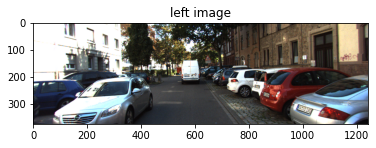

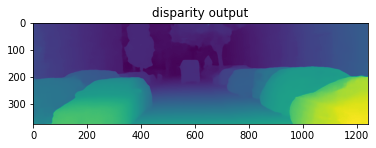

time = 2.84


In [42]:
def test_img(imgL,imgR):
      model.eval()

      imgL = imgL.cuda()
      imgR = imgR.cuda()     

      with torch.no_grad():
          disp = model(imgL,imgR)

      disp = torch.squeeze(disp)
      pred_disp = disp.data.cpu().numpy()

      return pred_disp
if __name__=='__main__':
    from collections import OrderedDict
    checkpoint = torch.load('/content/drive/MyDrive/ME459_stereo/pretrained_model_KITTI2015.tar')
    new_state_dict = OrderedDict()
    for k, v in checkpoint['state_dict'].items():
        name = k[7:]
        new_state_dict[name] = v    
    model.load_state_dict(new_state_dict)    
    normal_mean_var = {'mean': [0.485, 0.456, 0.406],
                        'std': [0.229, 0.224, 0.225]}
    infer_transform = transforms.Compose([transforms.ToTensor(),
                                          transforms.Normalize(**normal_mean_var)])    

    imgL_o = Image.open(left_image_path).convert('RGB')
    imgR_o = Image.open(right_image_path).convert('RGB')

    imgL = infer_transform(imgL_o)
    imgR = infer_transform(imgR_o) 

    # pad to width and hight to 16 times
    if imgL.shape[1] % 16 != 0:
        times = imgL.shape[1]//16       
        top_pad = (times+1)*16 -imgL.shape[1]
    else:
        top_pad = 0

    if imgL.shape[2] % 16 != 0:
        times = imgL.shape[2]//16                       
        right_pad = (times+1)*16-imgL.shape[2]
    else:
        right_pad = 0    

    imgL = F.pad(imgL,(0,right_pad, top_pad,0)).unsqueeze(0)
    imgR = F.pad(imgR,(0,right_pad, top_pad,0)).unsqueeze(0)

    start_time = time.time()
    pred_disp = test_img(imgL,imgR)
    if top_pad !=0 or right_pad != 0:
      img = pred_disp[top_pad:,:-right_pad]
    else:
      img = pred_disp
    plt.figure()
    plt.title('left image')
    plt.imshow(imgL_o)
    plt.figure()
    plt.title('disparity output')
    plt.imshow(img)
    plt.show()
    print('time = %.2f' %(time.time() - start_time))